In [1]:

import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:

file_path = "df.csv" 
data = pd.read_csv(file_path)


data['dance_type'] = data['images'].apply(lambda x: x.split('/')[1].split('_')[0])
data['video_id'] = data['images'].apply(lambda x: x.split('/')[1].split('_')[1]) 
data['camera_id'] = data['images'].apply(lambda x: x.split('/')[1].split('_')[2]) 

In [3]:

dance_video_stats = data.groupby(['dance_type', 'video_id']).size().reset_index(name='frame_count')

dance_type_summary = dance_video_stats.groupby('dance_type')['video_id'].count().reset_index(name='num_videos')

print(dance_type_summary)


  dance_type  num_videos
0     HipHop           6
1       Jazz           6
2       Kata           6
3     Taichi           6


In [4]:

def split_videos(dance_video_stats, train_ratio=0.7):
    train_videos, test_videos = {}, {}
    for dance_type in dance_video_stats['dance_type'].unique():
        videos = dance_video_stats[dance_video_stats['dance_type'] == dance_type]['video_id'].unique()
        random.shuffle(videos)
        split_idx = int(len(videos) * train_ratio)
        train_videos[dance_type] = videos[:split_idx] 
        test_videos[dance_type] = videos[split_idx:] 
    return train_videos, test_videos


train_videos, test_videos = split_videos(dance_video_stats)

#Training set split:
print("训练集划分：", {k: len(v) for k, v in train_videos.items()})
# Test set split:
print("测试集划分：", {k: len(v) for k, v in test_videos.items()})

训练集划分： {'HipHop': 4, 'Jazz': 4, 'Kata': 4, 'Taichi': 4}
测试集划分： {'HipHop': 2, 'Jazz': 2, 'Kata': 2, 'Taichi': 2}


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class DanceDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, num_frames=5):
        """
        Args:
            data (DataFrame): A DataFrame containing the columns `images` and `dance_type`.
            root_dir (str): The root directory of the `images` folder.
            transform (callable, optional): Transformations applied to the images.
            num_frames (int): The number of frames (time dimension) per sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames

        # print("Dataset Preview:")
        # print(self.data.head())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data.iloc[idx]['images'])

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"文件未找到：{image_path}")


        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)


        label = self.data.iloc[idx]['dance_type']
        label_mapping = {"HipHop": 0, "Jazz": 1, "Kata": 2, "Taichi": 3}
        label = label_mapping[label]


        image = image.unsqueeze(0).repeat(self.num_frames, 1, 1, 1)  # (time, height, width)
        # image = image.unsqueeze(0)  # (1, height, width)

        return image, label


In [6]:

train_video_ids = [video for videos in train_videos.values() for video in videos]
test_video_ids = [video for videos in test_videos.values() for video in videos]

train_data = data[data['video_id'].isin(train_video_ids)]
test_data = data[data['video_id'].isin(test_video_ids)]


# Number of training samples:
print(f"训练集样本数: {len(train_data)}")
# Number of testing samples:
print(f"测试集样本数: {len(test_data)}")

训练集样本数: 759
测试集样本数: 335


In [7]:

transform = transforms.Compose([
    transforms.Resize((250, 250)), 
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


root_dir = "segmentation_full_body_mads_dataset"
train_dataset = DanceDataset(train_data, root_dir=root_dir, transform=transform)
test_dataset = DanceDataset(test_data, root_dir=root_dir, transform=transform)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([16, 5, 3, 250, 250])
Batch labels: tensor([3, 1, 1, 3, 3, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1])


In [9]:

for i in range(5):  
    print(os.path.join(root_dir, train_data.iloc[i]['images']))


train_dataset = DanceDataset(train_data, root_dir=root_dir, transform=transform)


segmentation_full_body_mads_dataset/images/HipHop_HipHop3_C0_00045.png
segmentation_full_body_mads_dataset/images/HipHop_HipHop3_C0_00090.png
segmentation_full_body_mads_dataset/images/HipHop_HipHop3_C0_00135.png
segmentation_full_body_mads_dataset/images/HipHop_HipHop3_C0_00180.png
segmentation_full_body_mads_dataset/images/HipHop_HipHop3_C0_00225.png


In [10]:

dataset = DanceDataset(train_data, root_dir=root_dir, transform=transform)


image, label = dataset[0]
# image size
print(f"图像尺寸: {image.size}")  
# label
print(f"标签: {label}")         


图像尺寸: <built-in method size of Tensor object at 0x17d48b040>
标签: 0


In [11]:


for images, labels in train_loader:
    # images shape
    print(f"图像批次维度: {images.shape}")
    # labels
    print(f"标签批次: {labels}")
    break


图像批次维度: torch.Size([16, 5, 3, 250, 250])
标签批次: tensor([0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 3, 0, 1, 1, 3, 3])


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Dance3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Dance3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 1, 1)) 
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        if self.fc1 is None:
            fc1_input_dim = x.numel() // x.size(0)
            self.fc1 = nn.Linear(fc1_input_dim, 128).to(x.device)
            
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Dance3DCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [14]:
# from tqdm import tqdm

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
        # for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            images = images.permute(0, 2, 1, 3, 4)  # (batch_size, channels, time, height, width)
            # (batch_size, channels*time, height, width)
            # images = images.reshape(images.size(0), 3, images.size(2), images.size(3), images.size(4))

            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # train_loss /= len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(train_loss / len(train_loader))  
        # train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        
        

        # Validation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            # for images, labels in tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                images = images.permute(0, 2, 1, 3, 4) 
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

      
        # test_loss /= len(test_loader)
        test_accuracy = 100. * correct / total
        val_losses.append(test_loss / len(test_loader)) 
        val_accuracies.append(test_accuracy)
        print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%")


        for param_group in optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")
            


    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [15]:
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([16, 5, 3, 250, 250])
Batch labels: tensor([2, 1, 0, 1, 3, 2, 0, 0, 3, 1, 2, 2, 1, 1, 0, 0])


Epoch 1/10
Epoch 1/10, Train Loss: 54.5007, Train Accuracy: 56.65%
Validation Loss: 14.5163, Validation Accuracy: 74.63%
Learning Rate: 0.001
Epoch 2/10
Epoch 2/10, Train Loss: 19.1884, Train Accuracy: 84.06%
Validation Loss: 6.2776, Validation Accuracy: 86.87%
Learning Rate: 0.001
Epoch 3/10
Epoch 3/10, Train Loss: 8.9152, Train Accuracy: 92.75%
Validation Loss: 4.6430, Validation Accuracy: 90.45%
Learning Rate: 0.001
Epoch 4/10
Epoch 4/10, Train Loss: 4.9702, Train Accuracy: 97.36%
Validation Loss: 3.8949, Validation Accuracy: 91.64%
Learning Rate: 0.001
Epoch 5/10
Epoch 5/10, Train Loss: 3.6713, Train Accuracy: 97.50%
Validation Loss: 3.6176, Validation Accuracy: 92.54%
Learning Rate: 0.001
Epoch 6/10
Epoch 6/10, Train Loss: 2.9674, Train Accuracy: 98.02%
Validation Loss: 3.7161, Validation Accuracy: 91.94%
Learning Rate: 0.001
Epoch 7/10
Epoch 7/10, Train Loss: 2.1233, Train Accuracy: 98.42%
Validation Loss: 2.2980, Validation Accuracy: 94.93%
Learning Rate: 0.001
Epoch 8/10
Epoch 

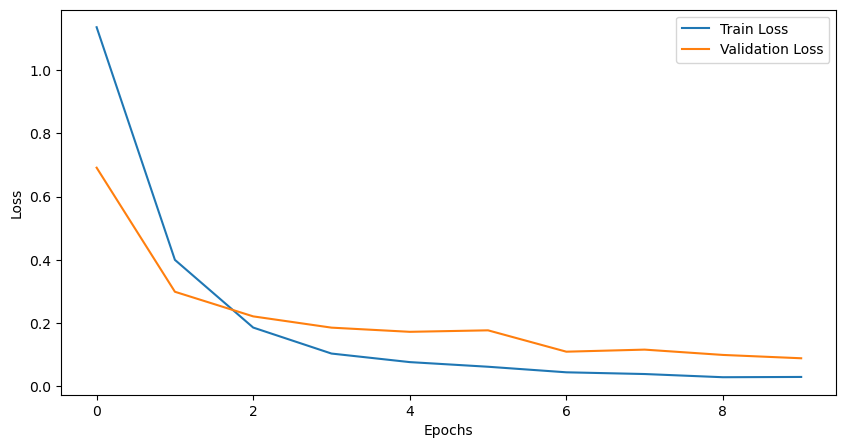

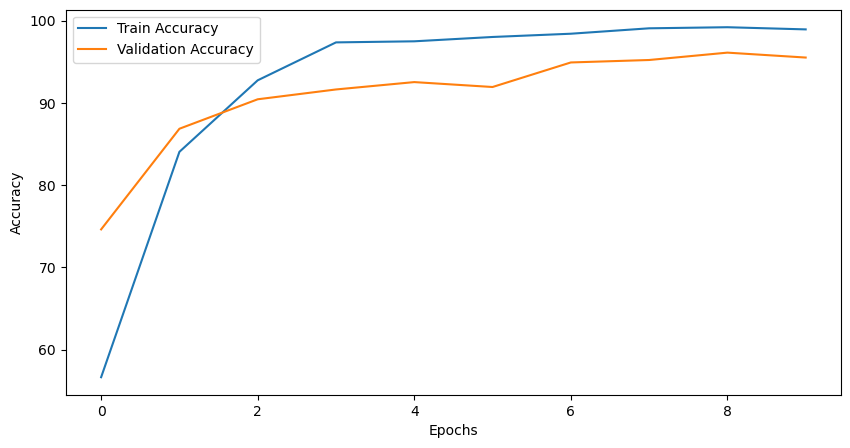

In [16]:
epochs = 10
train_model(model, train_loader, test_loader, criterion, optimizer, epochs)
torch.save(model.state_dict(),"ModelTry.pth")

In [17]:
state_dict = torch.load("ModelTry.pth", map_location=device)
for key, value in state_dict.items():
    print(f"{key}: {value.shape}")


conv1.weight: torch.Size([16, 3, 3, 3, 3])
conv1.bias: torch.Size([16])
conv2.weight: torch.Size([32, 16, 3, 3, 3])
conv2.bias: torch.Size([32])
fc2.weight: torch.Size([4, 128])
fc2.bias: torch.Size([4])
fc1.weight: torch.Size([128, 492032])
fc1.bias: torch.Size([128])
